In [1]:
%matplotlib notebook
import numpy as np
import cv2
import os
from scipy.spatial.distance import pdist,squareform
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from array2gif import write_gif

# predefine colormap
colormap= np.random.choice(range(256),size=(100,3))
#colormap=np.asarray([[255,0,0],[0,255,0],[0,0,255],[255,255,0],[0,255,255],[255,0,255],[255,255,255]],dtype=np.uint8)

def imread(path):
    '''
    @param path:
    @return: (H*W,C) flatten_image ndarray
    '''
    image = cv2.imread(path)
    H, W, C = image.shape
    image_flat = np.zeros((W * H, C))
    for h in range(H):
        image_flat[h * W:(h + 1) * W] = image[h]

    return image_flat,H,W

def precomputed_kernel(X,gamma_s=1,gamma_c=1):
    '''
    kernel function: k(x,x')= exp(-r_s*||S(x)-S(x')||**2)* exp(-r_c*||C(x)-C(x')||**2)
    :@param X: (H*W=10000,rgb=3) ndarray
    :@param gamma_s: gamma of spacial
    :@param gamma_c: gamma of color
    :@return : (10000,10000) ndarray
    '''
    n=len(X)
    # S(x) spacial ingormation
    S=np.zeros((n,2))
    for i in range(n):
        S[i]=[i//100,i%100]
    K=squareform(np.exp(-gamma_s*pdist(S,'sqeuclidean')))*squareform(np.exp(-gamma_c*pdist(X,'sqeuclidean')))

    return K

def visualize(X,k,H,W):
    '''
    @param X: (10000) belonging classes ndarray
    @param k: #clusters
    @param H: image_H
    @param W: image_W
    @return : (H,W,3) ndarray
    '''
    colors= colormap[:k,:] #select the color for ploting the cluster
    res=np.zeros((H,W,3))
    for h in range(H):
        for w in range(W):
            #print(X[h*W+w],colors.shape)
            res[h,w,:]=colors[X[h*W+w]]

    return res.astype(np.uint8)

def plot_eigenvector(xs,ys,zs,C):
    '''
    only for 3-dim datas
    @param xs: (#datapoint) ndarray
    @param ys: (#datapoint) ndarray
    @param zs: (#datapoint) ndarray
    @param C: (#datapoint) ndarray, belonging class
    '''
    fig=plt.figure()
    ax=Axes3D(fig)
    markers=['o','^','s']
    for marker,i in zip(markers,np.arange(3)):
        ax.scatter(xs[C==i],ys[C==i],zs[C==i],marker=marker)

    ax.set_xlabel('eigenvector 1st dim')
    ax.set_ylabel('eigenvector 2nd dim')
    ax.set_zlabel('eigenvector 3rd dim')
    #plt.show()

def save_gif(segments,gif_path):
    # use the array2gif
    for i in range(len(segments)):
        segments[i] = segments[i].transpose(1, 0, 2)
    write_gif(segments, gif_path, fps=2)
EPS=1e-9

def initial_mean(X,k,initType):
    '''
    @param X: (#datapoint,#features) ndarray
    @param k: #clusters
    @param initType: 'random','pick','k_means_plusplus'
    @return: (k,#features) ndarray, Kij: cluster i's j-dim value
    '''
    Cluster = np.zeros((k, X.shape[1]))
    if initType == 'k_means_plusplus':
        #pick 1 cluster_mean
        Cluster[0]=X[np.random.randint(low=0,high=X.shape[0],size=1),:]
        #pick k-1 cluster_mean
        for c in range(1,k):
            Dist=np.zeros((len(X),c))
            for i in range(len(X)):
                for j in range(c):
                    Dist[i,j]=np.sqrt(np.sum((X[i]-Cluster[j])**2))
            #choose the farest point to the next cluster_mean
            Dist_square = Dist**2
            Dist_max = np.argmax(Dist_square, axis=1)
            Cluster[c]=X[Dist_max[c-1]]
    elif initType=='pick':
        #random select by uniform distribution
        random_pick=np.random.randint(low=0,high=X.shape[0],size=k)
        Cluster=X[random_pick,:]
    else:
        #random select by normal distribution
        X_mean=np.mean(X,axis=0)
        X_std=np.std(X,axis=0)
        for c in range(X.shape[1]):
            Cluster[:,c]=np.random.normal(X_mean[c],X_std[c],size=k)

    return Cluster

def kmeans(X,k,H,W,initType='random'):
    '''
    k clusters
    @param X: (#datapoint,#features) ndarray
    @param k: # clusters
    @param H: image H
    @param W: image W
    @return: (#datapoint) ndarray, Ci: belonging class of each data point
    @return: ndarray list ready for gif
    '''
    #set the initialization
    Mean=initial_mean(X,k,initType)
    print('finish init')
    # Classes of each Xi
    C=np.zeros(len(X),dtype=np.uint8)
    segments=[]

    diff=1e9
    count=1
    while diff>EPS :
        # E-step
        #classify the class of each Xi
        for i in range(len(X)):
            dist=np.sqrt(np.sum((Mean-X[i])**2,axis=1))
            C[i]=np.argmin(dist)
        
        # M-step
        #calculate the center of each cluster (Ci)
        New_Mean=np.zeros(Mean.shape)
        for i in range(k):
            belong=np.argwhere(C==i).reshape(-1)
            for j in belong:
                New_Mean[i]=New_Mean[i]+X[j]
            if len(belong)>0:
                New_Mean[i]=New_Mean[i]/len(belong)

        diff = np.sum((New_Mean - Mean)**2)
        Mean=New_Mean

        # visualize
        segment = visualize(C,k,H,W)
        segments.append(segment)


        count+=1

    return C,segments

In [2]:
#PART1,2
img_path='image1.png'
image_flat,HEIGHT,WIDTH=imread(img_path)
gamma_s=0.001
gamma_c=0.001
k=3  # k clusters
k_means_initType='k_means_plusplus'
gif_path=os.path.join('GIF','{}_{}Clusters_{}'.format(img_path.split('.')[0],k,'kernel k-means.gif'))

Gram=precomputed_kernel(image_flat,gamma_s,gamma_c)

belongings,segments=kmeans(Gram,k,HEIGHT,WIDTH,initType=k_means_initType)
#save_gif(segments,gif_path)

finish init


In [5]:
segments[0].shape

(100, 100, 3)

In [19]:
#PART3
img_path='image1.png'
image_flat,HEIGHT,WIDTH=imread(img_path)
gamma_s=0.001
gamma_c=0.001
k=3  # k clusters
k_means_initType='k_means_plusplus'


Gram=precomputed_kernel(image_flat,gamma_s,gamma_c)
#kmeans
belongings,segments=kmeans(Gram,k,HEIGHT,WIDTH,initType=k_means_initType)
gif_path=os.path.join('PART3','{}_{}Clusters_{}'.format(k_means_initType,k,'kernel k-means.gif'))
save_gif(segments,gif_path)
belongings,segments=kmeans(Gram,k,HEIGHT,WIDTH,initType='pick')
k_means_initType = 'pick'
gif_path=os.path.join('PART3','{}_{}Clusters_{}'.format(k_means_initType,k,'kernel k-means.gif'))
save_gif(segments,gif_path)
belongings,segments=kmeans(Gram,k,HEIGHT,WIDTH)
k_means_initType = 'random_normal'
gif_path=os.path.join('PART3','{}_{}Clusters_{}'.format(k_means_initType,k,'kernel k-means.gif'))
save_gif(segments,gif_path)

finish init
finish init
finish init


In [22]:
#normalized spectral clustering
W=precomputed_kernel(image_flat,gamma_s,gamma_c)
# degree matrix
D=np.diag(np.sum(W,axis=1))
# laplacian matrix
L=D-W
D_inverse_square_root=np.diag(1/np.diag(np.sqrt(D)))
L_sym=D_inverse_square_root@L@D_inverse_square_root
# calculate the eigenvalue and eigenvector
eigenvalue,eigenvector=np.linalg.eig(L_sym)
sort_index=np.argsort(eigenvalue)
# U:(n,k)
U=eigenvector[:,sort_index[1:1+k]]
# normalized
# T:(n,k) each row with norm 1
sums=np.sqrt(np.sum(np.square(U),axis=1)).reshape(-1,1)
T=U/sums

# k-means
k_means_initType='k_means_plusplus'
belongings,segments=kmeans(Gram,k,HEIGHT,WIDTH,initType=k_means_initType)
gif_path=os.path.join('PART3','{}_{}Clusters_{}'.format(k_means_initType,k,'normalized.gif'))
save_gif(segments,gif_path)

finish init


finish init


<IPython.core.display.Javascript object>


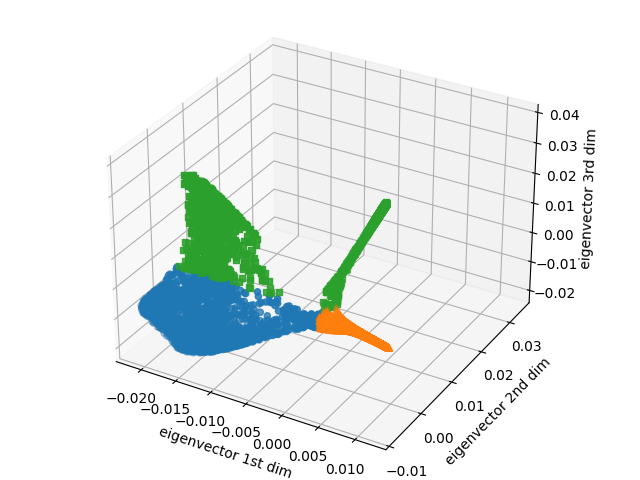

In [18]:
#normalized spectral clustering
gif_path=os.path.join('GIF','{}_{}Clusters_{}'.format(img_path.split('.')[0],k,'normalized.gif'))
# similarity matrix
W=precomputed_kernel(image_flat,gamma_s,gamma_c)
# degree matrix
D=np.diag(np.sum(W,axis=1))
# laplacian matrix
L=D-W
D_inverse_square_root=np.diag(1/np.diag(np.sqrt(D)))
L_sym=D_inverse_square_root@L@D_inverse_square_root
# calculate the eigenvalue and eigenvector
eigenvalue,eigenvector=np.linalg.eig(L_sym)
sort_index=np.argsort(eigenvalue)
# U:(n,k)
U=eigenvector[:,sort_index[1:1+k]]
# normalized
# T:(n,k) each row with norm 1
sums=np.sqrt(np.sum(np.square(U),axis=1)).reshape(-1,1)
T=U/sums

# k-means
belonging,segments=kmeans(T,k,HEIGHT,WIDTH,initType=k_means_initType)

save_gif(segments,gif_path)
if k==3:
    plot_eigenvector(U[:,1],U[:,0],U[:,2],belonging)

Calculating...
Calculating eigenvalue...
finish init


<IPython.core.display.Javascript object>


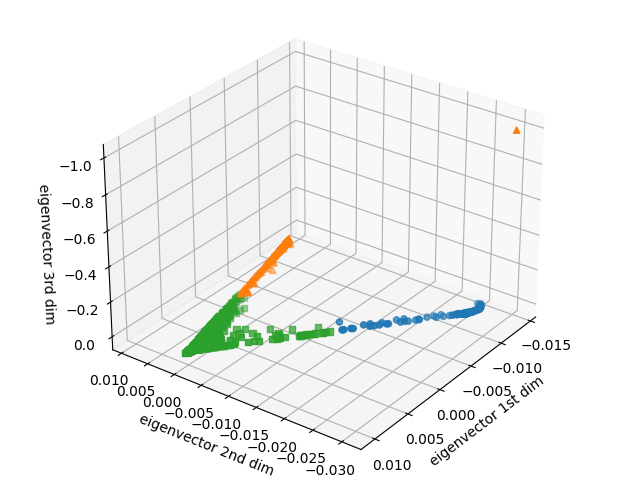

In [9]:
#ratio spectral clustering
# set parameters
#img_path='image2.png'
image_flat,HEIGHT,WIDTH=imread(img_path)
gamma_s=0.001
gamma_c=0.001
k_means_initType='k_means_plusplus'
#k=3  # k clusters
gif_path=os.path.join('GIF','{}_{}Clusters_{}'.format(img_path.split('.')[0],k,'ratio.gif'))
print('Calculating...')
# similarity matrix
W=precomputed_kernel(image_flat,gamma_s,gamma_c)
# degree matrix
D=np.diag(np.sum(W,axis=1))
# laplacian matrix
L=D-W
# calculate the eigenvalue and eigenvector
eigenvalue,eigenvector=np.linalg.eig(L)
sort_index=np.argsort(eigenvalue)
# U
U=eigenvector[:,sort_index[1:1+k]]

# k-means
belonging,segments=kmeans(U,k,HEIGHT,WIDTH,initType=k_means_initType)

save_gif(segments,gif_path)
if k==3:
    plot_eigenvector(U[:,1],U[:,0],U[:,2],belonging)

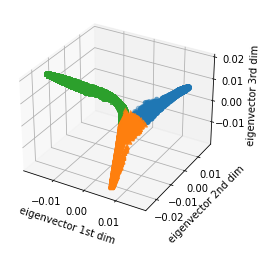

In [27]:
plot_eigenvector(U[:,0],U[:,2],U[:,1],belonging)